# Data Science Project

### Yikun Liu

## Libraries

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor as knr
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.simplefilter(action='ignore')

## Primary Exploration

In [2]:
train = pd.read_csv('Data Science ZExercise_TRAINING_CONFIDENTIAL1.csv')
test = pd.read_csv('Data Science ZExercise_TEST_CONFIDENTIAL2.csv')

In [3]:
train.shape

(11588, 24)

In [4]:
test.shape

(4402, 24)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11588 entries, 0 to 11587
Data columns (total 24 columns):
PropertyID            11588 non-null int64
SaleDollarCnt         11588 non-null float64
TransDate             11588 non-null object
censusblockgroup      11588 non-null float64
ZoneCodeCounty        11588 non-null object
Usecode               11588 non-null int64
BedroomCnt            11588 non-null float64
BathroomCnt           11588 non-null float64
FinishedSquareFeet    11588 non-null float64
GarageSquareFeet      8747 non-null float64
LotSizeSquareFeet     11588 non-null int64
StoryCnt              11588 non-null float64
BuiltYear             11588 non-null float64
ViewType              2632 non-null float64
Latitude              11588 non-null int64
Longitude             11588 non-null int64
BGMedHomeValue        11582 non-null float64
BGMedRent             8957 non-null float64
BGMedYearBuilt        11341 non-null float64
BGPctOwn              11588 non-null float64
BGPctV

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4402 entries, 0 to 4401
Data columns (total 24 columns):
PropertyID            4402 non-null int64
SaleDollarCnt         0 non-null float64
TransDate             4402 non-null object
censusblockgroup      4402 non-null float64
ZoneCodeCounty        4402 non-null object
Usecode               4402 non-null int64
BedroomCnt            4402 non-null float64
BathroomCnt           4402 non-null float64
FinishedSquareFeet    4402 non-null int64
GarageSquareFeet      3264 non-null float64
LotSizeSquareFeet     4402 non-null int64
StoryCnt              4402 non-null float64
BuiltYear             4402 non-null float64
ViewType              998 non-null float64
Latitude              4402 non-null int64
Longitude             4402 non-null int64
BGMedHomeValue        4395 non-null float64
BGMedRent             3439 non-null float64
BGMedYearBuilt        4340 non-null float64
BGPctOwn              4402 non-null float64
BGPctVacant           4402 non-

## Feature Engineering

To maintain consistency between the `train` and `test` sets, first merge the `train` and `test` datasets.

In [7]:
merged = pd.concat([train,test],axis=0)

### Extract Date Information

Transform `TransDate` to date type, and extract Transaction month and name as `TransMonth`. Since all the transactions happened in 2015, the transaction months may contain information.

In [8]:
merged['TransDate'] = pd.to_datetime(merged['TransDate'], format="%m/%d/%Y")
merged['TransMonth'] = merged['TransDate'].dt.month
merged=merged.drop(columns=['TransDate'])

### Remove columns with no information contribution

Derive the census tract FIPS by truncating the rightmost digit of `censusblockgroup`, and read the census tract FIPS.

In [9]:
merged.censusblockgroup = (merged.censusblockgroup - merged.censusblockgroup % 10)/10
merged.censusblockgroup.value_counts()

5.300000e+10    15990
Name: censusblockgroup, dtype: int64

It turns out that `censusblockgroup` only has one value. Therefore, it will not contribute infomation. Remove this column.

In [10]:
merged=merged.drop(columns=['censusblockgroup'])

Read `Usecode`. It turns out that `Usecode` only has one value, because all homes in both training and test are single-family homes. Therefore, it will not contribute infomation. Remove this column.

In [11]:
merged.Usecode.value_counts()
merged=merged.drop(columns=['Usecode'])

### Change Categorical Variables to Dummies

`ZoneCodeCounty` stands for the intensity of use or density the lot is legally allowed to be built-up to, and can affect a home's current market value. Change this categorical variable into dummy variables. There are about 100 to 200 categories in `ZoneCodeCounty`, not to sparse for tree model training.

In [12]:
dummy=pd.get_dummies(merged.ZoneCodeCounty,prefix='Zone')
merged=pd.concat([merged,dummy],axis=1)
merged=merged.drop(columns=['ZoneCodeCounty'])

`ViewType` is a nominal variable indicating the type of view from the home (blank or NULL value indicates no view). Therefore, we should regard it as a categorical variable, and `NaN` is one of the categories. Change the variable type into "object", and get dummies. 

In [13]:
merged.ViewType = merged.ViewType.astype(object)
dummy=pd.get_dummies(merged.ViewType,prefix='View',dummy_na=True)
merged=pd.concat([merged,dummy],axis=1)
merged=merged.drop(columns=['ViewType'])

### Deal with Missing Data

#### Impute with 0

`GarageSquareFeet` stands for the size of protected garage space if any. Therefore, `NaN` means that there is 0 protected garage space. Replace `NaN` with 0.

In [14]:
merged.GarageSquareFeet = merged.GarageSquareFeet.fillna(0)

Split the `merged` set back to `train` and `test` datasets.

In [15]:
train = merged[:train.shape[0]]
test = merged[train.shape[0]:]

#### Impute with regression

Now, let's see which columns in `train` and `test` set have missing values and how many missing values there are.

In [16]:
null_train=train.columns[train.isnull().any()]
train[null_train].isnull().sum()

BGMedHomeValue       6
BGMedRent         2631
BGMedYearBuilt     247
dtype: int64

In [17]:
null_test=test.columns[test.isnull().any()]
test[null_test].isnull().sum()

SaleDollarCnt     4402
BGMedHomeValue       7
BGMedRent          963
BGMedYearBuilt      62
dtype: int64

Despite the `SaleDollarCnt` column that we are going to do prediction on in `test` set, there are still missing values in columns __`BGMedHomeValue`,`BGMedRent`, and `BGMedYearBuilt`__ in both train and test dataset. To deal with these missing data, there are 4 ways that can be considered:

- Remove the columns
- Remove the rows with missing data
- Replace the missing data simply with means or medians
- Impute the missing data with regression

Here, in both sets, rows with `NaN` takes up about 20%. For train set, we have a pretty large dataset, and using 80% is acceptable. However, removing rows or columns means losing information, and 20% information loss can be a price. For test set, all records should be scored by the model regardless of the presence of missing values on any of the variables in the model, which means we cannot remove any of the rows with missing values. Therefore, we choose to impute the missing values in these 3 columns.

Since replacing missing data with means or medians may increase error, imputing them with regression looks like a good choice. Here we choose __KNN regression__ to perform the imputation. __We will do the regression based on KNN models trained separately from `train` and `test` set to avoid data leakage.__

Let's see how many missing values are in each row of `train` and `test` set. The reason why we concern about the number of missing values for each row is that, for rows containing more than one NaN, we might have to run the regression models iterately to reach a convergent imputation.

In [18]:
# Eliminate the first two columns of test 
train_im=train.iloc[:,2:]
test_im=test.iloc[:,2:]

print(train_im.isnull().sum(axis=1).value_counts())
print(test_im.isnull().sum(axis=1).value_counts())

0    8713
1    2866
2       9
dtype: int64
0    3373
1    1026
2       3
dtype: int64


Most rows only contains 1 missing value, and here are very few rows that has 2 missing values. For the `train` set, doing iterate KNN regressions for these 9 rows is not necessary, so we remove them. For `test` set, we have to keep them, and do iterate KNN regressions later.

In [19]:
train_im=train_im[train_im.isnull().sum(axis=1)!=2]

__Function knnregr()__

In order to simplify the following KNN regression process, write a function named __`knnregr`__. 

The function will:

1. take xtrain (predictors for training), ytrain (outcomes for training), and xtest (preditors for regression) as arguments; 
1. standardize each predictors; 

1. split the training data into a sub-training set (80%) and a validation set (20%); 

1. select the optimal k through cross-validation based on mean squared error; 

1. return the KNN regression outcome as an array.

In [20]:
def knnregr(xtrain, xtest, ytrain):
    ## --standardize each column in xtrain and xtest-- ##
    tem=pd.concat([xtrain,xtest])
    tem=preprocessing.scale(tem)
    
    xtrain = pd.DataFrame(tem[:xtrain.shape[0]])
    xtest = pd.DataFrame(tem[xtrain.shape[0]:])

    ## --split the training data into a sub-training set (80%) and a validation set (20%)-- ##
    x_subtrain, x_valid, y_subtrain, y_valid = train_test_split(xtrain, ytrain, test_size=0.20,random_state=1)
           
    ## --optimize k using MSE metrics-- ##
    mse =[]
    k_opt=0
    for k in range(1,16):
        regr = knr(n_neighbors=k)
        regr.fit(x_subtrain, y_subtrain)
        y_valid_pred = regr.predict(x_valid)
        mse.append(mean_squared_error(y_valid,y_valid_pred))
    
    for i in range(0,15):
        if mse[i] == min(mse):
            k_opt=i+1
    
    ## --use the optimized k to get a prediction: ytest-- ##
    regr_opt = knr(n_neighbors=k_opt)
    regr_opt.fit(xtrain, ytrain)
    ytest = regr_opt.predict(xtest)

    return(ytest)

__Handle NaN in the `train` set__

`train_im` is the dataframe that contains rows without missing value and rows with only one missing value from the "predictor side" (columns other than the first two) in the `train` set. Use rows without any missing value, named `train_im_full` as the training set of KNN regression models, and 3 pairs of "xtrain" and "ytrain" are selected from `train_im_full` to predict `BGMedHomeValue`, `BGMedRent`, or `BGMedYearBuilt`.

In [21]:
train_im_full=train_im.dropna()

xtrain_im1=train_im_full.drop(columns=['BGMedHomeValue'])
ytrain_im1=train_im_full.BGMedHomeValue

xtrain_im2=train_im_full.drop(columns=['BGMedRent'])
ytrain_im2=train_im_full.BGMedRent

xtrain_im3=train_im_full.drop(columns=['BGMedYearBuilt'])
ytrain_im3=train_im_full.BGMedYearBuilt

Select dataframes named `x_HomeValue_train`, `x_Rent_train`, and `x_YearBuilt_train` for the 3 "xtest" from `train_im` where values in columns `BGMedHomeValue`, `BGMedRent`, or `BGMedYearBuilt` are missing. 

In [22]:
x_HomeValue_train=train_im[train_im.BGMedHomeValue.isnull()].drop(columns=['BGMedHomeValue'])
x_Rent_train=train_im[train_im.BGMedRent.isnull()].drop(columns=['BGMedRent'])
x_YearBuilt_train=train_im[train_im.BGMedYearBuilt.isnull()].drop(columns=['BGMedYearBuilt'])

Call knnregr() and get 3 "ytest" as results, named `HomeValue_train`, `Rent_train`, and `YearBuilt_train`. Convert them into dataframes with original indexes in `train` set for replacement convenience.

In [23]:
HomeValue_train=knnregr(xtrain_im1, x_HomeValue_train, ytrain_im1)
Rent_train=knnregr(xtrain_im2, x_Rent_train, ytrain_im2)
YearBuilt_train=knnregr(xtrain_im3, x_YearBuilt_train, ytrain_im3)

HomeValue_train_df=pd.DataFrame(HomeValue_train,index=x_HomeValue_train.index)
Rent_train_df=pd.DataFrame(Rent_train,index=x_Rent_train.index)
YearBuilt_train_df=pd.DataFrame(YearBuilt_train,index=x_YearBuilt_train.index)

Finally, replace the missing values in `train` set with data from regression for each 3 columns.

In [24]:
for i in HomeValue_train_df.index:
    train.BGMedHomeValue[i]=HomeValue_train_df[0][i]
    
for i in Rent_train_df.index:
    train.BGMedRent[i]=Rent_train_df[0][i]

for i in YearBuilt_train_df.index:
    train.BGMedYearBuilt[i]=YearBuilt_train_df[0][i]

In [25]:
train=train.dropna()

Now we finish imputing `train` set. 

In [26]:
train.iloc[:,:20].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11579 entries, 0 to 11587
Data columns (total 20 columns):
PropertyID            11579 non-null int64
SaleDollarCnt         11579 non-null float64
BedroomCnt            11579 non-null float64
BathroomCnt           11579 non-null float64
FinishedSquareFeet    11579 non-null float64
GarageSquareFeet      11579 non-null float64
LotSizeSquareFeet     11579 non-null int64
StoryCnt              11579 non-null float64
BuiltYear             11579 non-null float64
Latitude              11579 non-null int64
Longitude             11579 non-null int64
BGMedHomeValue        11579 non-null float64
BGMedRent             11579 non-null float64
BGMedYearBuilt        11579 non-null float64
BGPctOwn              11579 non-null float64
BGPctVacant           11579 non-null float64
BGMedIncome           11579 non-null int64
BGPctKids             11579 non-null float64
BGMedAge              11579 non-null float64
TransMonth            11579 non-null int64
dty

__Handle NaN in the `test` set__

The process of imputing `test` set is very similar to imputing `train` set. First, select 3 pairs of "xtrain" and "ytrain" from `test_im_full` to predict `BGMedHomeValue`, `BGMedRent`, or `BGMedYearBuilt`.

In [27]:
test_im_full=test_im.dropna()

xtest_im1=test_im_full.drop(columns=['BGMedHomeValue'])
ytest_im1=test_im_full.BGMedHomeValue

xtest_im2=test_im_full.drop(columns=['BGMedRent'])
ytest_im2=test_im_full.BGMedRent

xtest_im3=test_im_full.drop(columns=['BGMedYearBuilt'])
ytest_im3=test_im_full.BGMedYearBuilt

There are 3 rows in the `test` set that contain missing value both from `BGMedRent` and `BGMedYearBuilt`. We will do KNN regression iterately between these two columns. Let's first do what we did before.

In [28]:
test_1=test_im[test_im.isnull().sum(axis=1)!=2]

x_HomeValue_test=test_1[test_1.BGMedHomeValue.isnull()].drop(columns=['BGMedHomeValue'])
x_Rent_test=test_1[test_1.BGMedRent.isnull()].drop(columns=['BGMedRent'])
x_YearBuilt_test=test_1[test_1.BGMedYearBuilt.isnull()].drop(columns=['BGMedYearBuilt'])

In [29]:
HomeValue_test=knnregr(xtest_im1, x_HomeValue_test, ytest_im1)
Rent_test=knnregr(xtest_im2, x_Rent_test, ytest_im2)
YearBuilt_test=knnregr(xtest_im3, x_YearBuilt_test, ytest_im3)

In [30]:
HomeValue_test_df=pd.DataFrame(HomeValue_test,index=x_HomeValue_test.index)
Rent_test_df=pd.DataFrame(Rent_test,index=x_Rent_test.index)
YearBuilt_test_df=pd.DataFrame(YearBuilt_test,index=x_YearBuilt_test.index)

In [31]:
for i in HomeValue_test_df.index:
    test.BGMedHomeValue[i]=HomeValue_test_df[0][i]

for i in Rent_test_df.index:
    test.BGMedRent[i]=Rent_test_df[0][i]

for i in YearBuilt_test_df.index:
    test.BGMedYearBuilt[i]=YearBuilt_test_df[0][i]

Now we finish imputing rows that only contains 1 missing value. There are 3 rows left.

Select these 3 rows out and name as `x_RentYear_test`. Then fill the `BGMedRent` in `x_RentYear_test` with mean of `BGMedRent` in `test_im_full` as a starting point.

In [32]:
x_RentYear_test=test_im[test_im.isnull().sum(axis=1)==2]

In [33]:
x_RentYear_test.BGMedRent=x_RentYear_test.BGMedRent.fillna(test_im_full.BGMedRent.mean())
x_RentYear_test.BGMedRent

3163    1211.293507
3164    1211.293507
3165    1211.293507
Name: BGMedRent, dtype: float64

Start from regression on column `BGMedYearBuilt`, and then with the updated `BGMedYearBuilt`, do regression on column `BGMedRent`... Each time print out the regression result, and when the results converge, we can stop.

In [34]:
# The 1st regression
RYx_1=x_RentYear_test.drop(columns=['BGMedYearBuilt'])

RYmodel_1=knnregr(xtest_im3, RYx_1, ytest_im3)

RYdf_1=pd.DataFrame(RYmodel_1,index=RYx_1.index)

for i in RYdf_1.index:
    x_RentYear_test.BGMedYearBuilt[i]=RYdf_1[0][i]

x_RentYear_test.BGMedYearBuilt

3163    1976.666667
3164    1976.666667
3165    1974.666667
Name: BGMedYearBuilt, dtype: float64

In [35]:
# The 2nd regression
RYx_2=x_RentYear_test.drop(columns=['BGMedRent'])

RYmodel_2=knnregr(xtest_im2, RYx_2, ytest_im2)

RYdf_2=pd.DataFrame(RYmodel_2,index=RYx_2.index)

for i in RYdf_2.index:
    x_RentYear_test.BGMedRent[i]=RYdf_2[0][i]

x_RentYear_test.BGMedRent

3163    718.0
3164    718.0
3165    718.0
Name: BGMedRent, dtype: float64

In [36]:
# The 3rd regression
RYx_3=x_RentYear_test.drop(columns=['BGMedYearBuilt'])

RYmodel_3=knnregr(xtest_im3, RYx_3, ytest_im3)

RYdf_3=pd.DataFrame(RYmodel_3,index=RYx_3.index)

for i in RYdf_3.index:
    x_RentYear_test.BGMedYearBuilt[i]=RYdf_3[0][i]
    
x_RentYear_test.BGMedYearBuilt

3163    1976.666667
3164    1976.666667
3165    1976.666667
Name: BGMedYearBuilt, dtype: float64

In [37]:
# The 4th regression
RYx_4=x_RentYear_test.drop(columns=['BGMedRent'])

RYmodel_4=knnregr(xtest_im2, RYx_4, ytest_im2)

RYdf_4=pd.DataFrame(RYmodel_4,index=RYx_4.index)

for i in RYdf_4.index:
    x_RentYear_test.BGMedRent[i]=RYdf_4[0][i]

x_RentYear_test.BGMedRent

3163    718.0
3164    718.0
3165    718.0
Name: BGMedRent, dtype: float64

In [38]:
# The 5th regression
RYx_5=x_RentYear_test.drop(columns=['BGMedYearBuilt'])

RYmodel_5=knnregr(xtest_im3, RYx_5, ytest_im3)

RYdf_5=pd.DataFrame(RYmodel_5,index=RYx_5.index)

for i in RYdf_5.index:
    x_RentYear_test.BGMedYearBuilt[i]=RYdf_5[0][i]
    
x_RentYear_test.BGMedYearBuilt

3163    1976.666667
3164    1976.666667
3165    1976.666667
Name: BGMedYearBuilt, dtype: float64

Now the 2 columns both converge. Replace the missing values in `test` set from rows that have 2 NaN with data from `x_RentYear_test` for column `BGMedRent` and `BGMedYearBuilt`.

In [39]:
for i in x_RentYear_test.index:
    test.BGMedRent[i]=x_RentYear_test.BGMedRent[i]
    test.BGMedYearBuilt[i]=x_RentYear_test.BGMedYearBuilt[i]

All the columns except `SaleDollarCnt` don't have any missing value now.

In [40]:
test.iloc[:,:20].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4402 entries, 0 to 4401
Data columns (total 20 columns):
PropertyID            4402 non-null int64
SaleDollarCnt         0 non-null float64
BedroomCnt            4402 non-null float64
BathroomCnt           4402 non-null float64
FinishedSquareFeet    4402 non-null float64
GarageSquareFeet      4402 non-null float64
LotSizeSquareFeet     4402 non-null int64
StoryCnt              4402 non-null float64
BuiltYear             4402 non-null float64
Latitude              4402 non-null int64
Longitude             4402 non-null int64
BGMedHomeValue        4402 non-null float64
BGMedRent             4402 non-null float64
BGMedYearBuilt        4402 non-null float64
BGPctOwn              4402 non-null float64
BGPctVacant           4402 non-null float64
BGMedIncome           4402 non-null int64
BGPctKids             4402 non-null float64
BGMedAge              4402 non-null float64
TransMonth            4402 non-null int64
dtypes: float64(14), int64(6

### Remove Outliners

Print graghs of all the remaining numerial features. We assume that there is no outliners in categorical features.

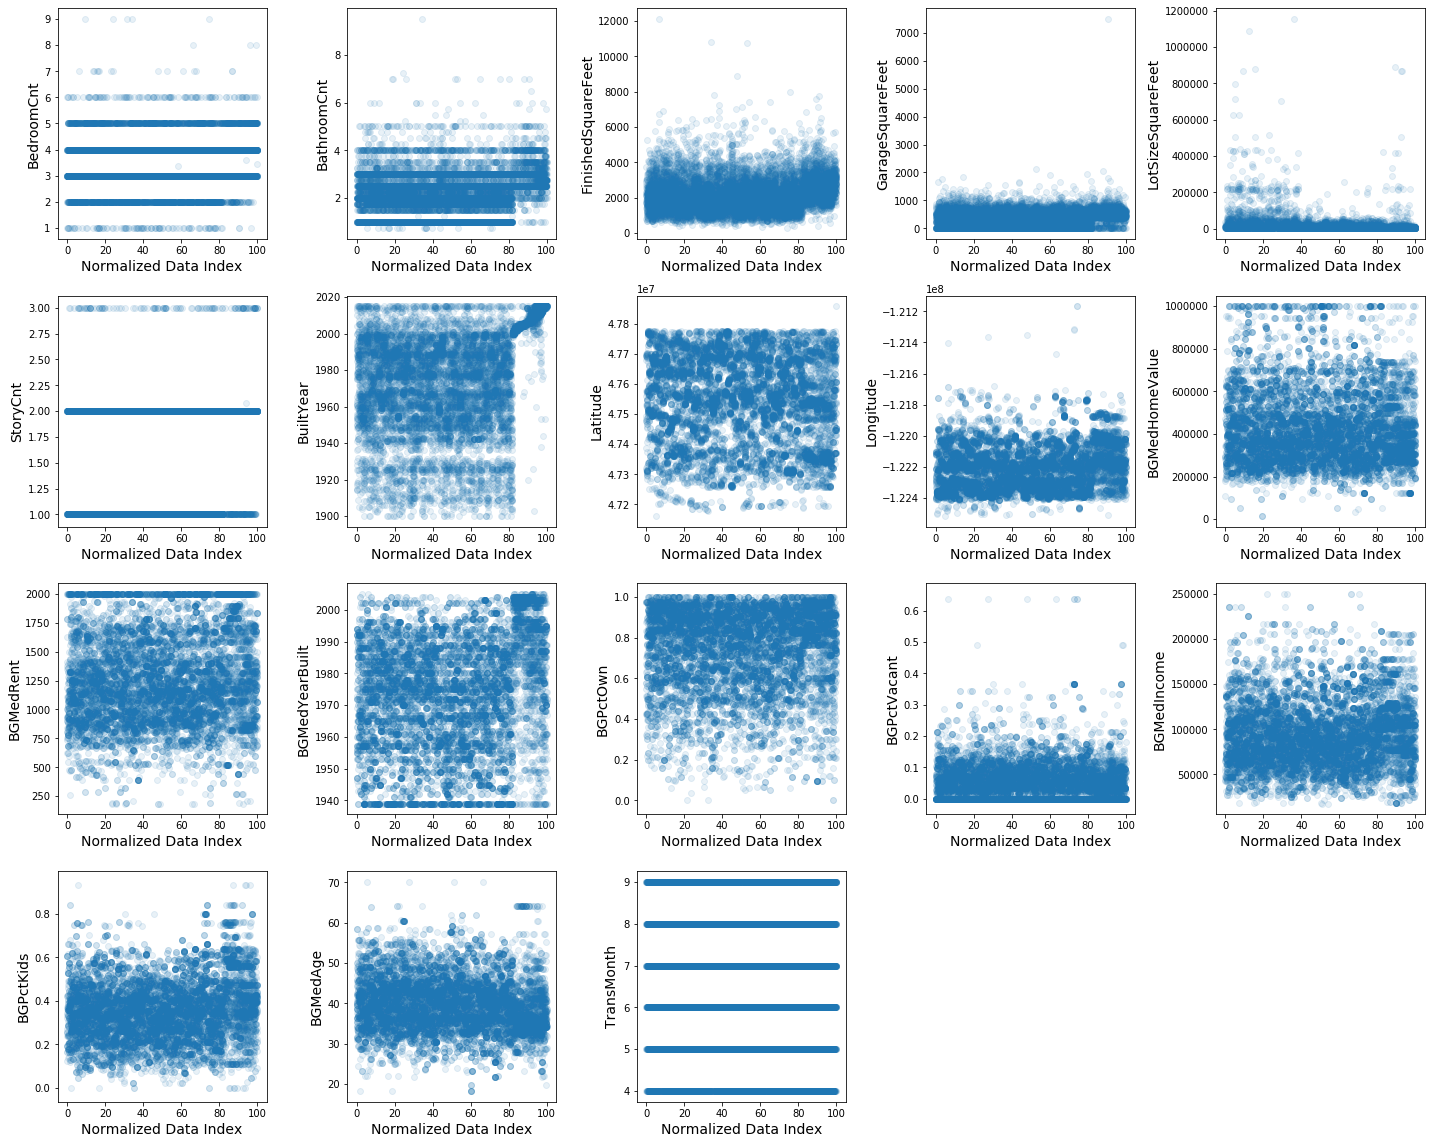

In [41]:
plt.figure(figsize=(20,16))
subplot_count = 1;
for column in train.iloc[:,2:20]:
    plt.subplot(4, 5, subplot_count); subplot_count += 1
    plt.scatter(np.arange(0,100.0,100.0/len(train)), train[column], alpha=0.1)
    plt.xlabel("Normalized Data Index", fontsize=14)
    plt.ylabel(column, fontsize=14)
plt.tight_layout()
plt.show()

From the graphs, we observe that `FinishedSquareFeet`, `GarageSquareFeet`, and `LotSizeSquareFeet` have outliners with super high values, and `BGMedHomeValue` has outlines with super low values. 

Remove outliner above thersholds in `FinishedSquareFeet`, `GarageSquareFeet`, and `LotSizeSquareFeet`.

In [42]:
train.drop(train[train['FinishedSquareFeet']>8000].index, inplace = True)
train.drop(train[train['GarageSquareFeet']>5000].index, inplace = True)
train.drop(train[train['LotSizeSquareFeet']>1000000].index, inplace = True)

As for `BGMedHomeValue`, first calculate price per square foot as `PriceSF` (=`BGMedHomeValue`/`FinishedSquareFeet`).From a news report, housing price per square foot in Seattle Area ranged from 185 to 2,408 dollars in 2017. Suppose a 5% increase every year, and we can conclude that the reasonable price per square foot in 2015 should be 10--2500. After we finish removing outliners, we drop the temporary column `PriceSF`.

In [43]:
train['PriceSF']=train.BGMedHomeValue/train.FinishedSquareFeet
train.drop(train[train['PriceSF']<10].index, inplace = True)
train.drop(train[train['PriceSF']>2500].index, inplace = True)
train=train.drop(columns=['PriceSF'])

In [44]:
train.shape

(11571, 223)

Now we finish feature engineering. Split the `train` set into predictors: `x_train`, and outcome: `y_train`.

In [45]:
x_train = train.iloc[:,2:]
y_train = train.iloc[:,1]

## Model Selection

We use regression models for this problem. There are several kinds of regression models we can use:

- Linear regression
- KNN regression
- Decision tree
- Ensemble methods

Normally, linear regression and KNN regression set the baseline of the prediction error, because the decision boundaries are probably not linear. Ensemble methods are more robust and less biased than decision tree model. Therefore, we try the following 4 regression models and select a good one:

1. Linear regression
1. KNN regression
1. Random forest
1. Gradient boosting machine

First, split the `train` set into subtrain and cross validation sets, and use the same splitted sets for model selection.

In [46]:
x_subtrain, x_valid, y_subtrain, y_valid = train_test_split(x_train, y_train, test_size=0.20, random_state=1)

Define funnctions to caculate AAPE and MAPE to evaluate model performance.

In [47]:
def aape(pred_y, test_y):
    diffs = np.absolute(test_y - pred_y)
    diffs = np.divide(diffs,test_y)
    return np.mean(diffs)
def mape(pred_y, test_y):
    diffs = np.absolute(test_y - pred_y)
    diffs = np.divide(diffs,test_y)
    return np.median(diffs)

### Linear Regression: Lasso

First, we try linear regression. Feature selection is important for linear regression models to reduce overfitting, and __Lasso__ does feature selection with easy implementation for us. So we train Lasso on subtrain set and cross-validate with AAPE and MAPE.

In [48]:
%%time
model = linear_model.Lasso(alpha=0.1)
model.fit(x_subtrain,y_subtrain)

print(aape(model.predict(x_valid),y_valid))
print(mape(model.predict(x_valid),y_valid))

0.22647438117431112
0.1735891141849252
CPU times: user 7.44 s, sys: 1.93 s, total: 9.37 s
Wall time: 1.59 s


In [ ]:
coef = pd.Series(model.coef_, index = x_subtrain.columns)
coef

As we can see, the Average Absolute Percent Error is more than 15%. This is a bit too much.

### KNN Regression

Second, let's try KNN regression. The selection of k, which is the number of neighbors the model refers to, is the most important parameter to tune in the KNN model.

In [49]:
# Make a copy of x_train and standardize every column
x_train_copy=preprocessing.scale(x_train)

# Train KNN models with differet k and calculate AAPEs and MAPEs.
x_subtrain, x_valid, y_subtrain, y_valid = train_test_split(x_train_copy, y_train, test_size=0.20, random_state=1)
MAPE_KNN=[]
AAPE_KNN=[]
for k in range(1,11):
    knn_model = knr(n_neighbors=k)
    knn_model.fit(x_subtrain, y_subtrain)
    MAPE_KNN.append(mape(knn_model.predict(x_valid),y_valid))
    AAPE_KNN.append(aape(knn_model.predict(x_valid),y_valid))

Plot error graghs with different k to find the best k.

Text(0, 0.5, 'AAPE')

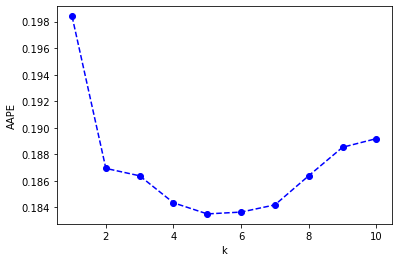

In [50]:
plt.plot(range(1,11), AAPE_KNN,linestyle='--', marker='o', color='b')
plt.xlabel("k") 
plt.ylabel("AAPE")

Text(0, 0.5, 'MAPE')

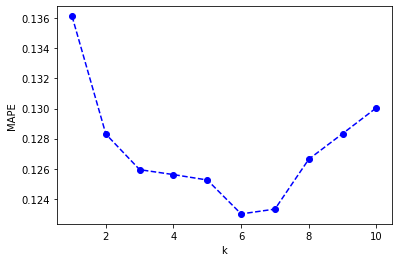

In [51]:
plt.plot(range(1,11), MAPE_KNN,linestyle='--', marker='o', color='b')
plt.xlabel("k") 
plt.ylabel("MAPE")

Looks like __k=6__ is the best choice with least error. Run KNN regression again with k=6, and report AAPE, MAPE.

In [52]:
%%time
knn_model = knr(n_neighbors=6)
knn_model.fit(x_subtrain, y_subtrain)

print(aape(knn_model.predict(x_valid),y_valid))
print(mape(knn_model.predict(x_valid),y_valid))

0.18364321831487743
0.123
CPU times: user 10.9 s, sys: 28 ms, total: 10.9 s
Wall time: 10.9 s


The error is still too much.

### Random Forest

Comparing with linear models, random forest is robust to outliers and non-linear data. It also reduces variance, which should give better perfomance.

Tuning parameters in the random forest regression model is time-consuming. At this stage, we want to select a good model quickly. Instead of delicated tuning, we choose parameters that should work fine and see the results. For the parameter "max_features", we use the experimental formula $m=p/3$. Here p, the number of features = 223, so we set m as 70.

In [53]:
%%time
regr_rf = RandomForestRegressor(n_estimators = 100, max_features = 70, criterion = 'mse', n_jobs = -1)
regr_rf.fit(x_subtrain, y_subtrain)
pred_y = regr_rf.predict(x_valid)

print(aape(pred_y,y_valid))
print(mape(pred_y,y_valid))

0.12965565296806714
0.08321929368995067
CPU times: user 12.7 s, sys: 60.1 ms, total: 12.8 s
Wall time: 1.35 s


### Gradient Boosting Machine

Gradient boosting machine has similar pros as random forest, but it tends to consume more time.

We use the same parameters as the random forest model, and other parameters as default to keep things as comparable as possible. 

In [54]:
%%time
regr_gb = GradientBoostingRegressor(n_estimators = 100, max_features = 70, criterion = 'mse')
regr_gb.fit(x_subtrain, y_subtrain)
pred_y = regr_gb.predict(x_valid)

print(aape(pred_y,y_valid))
print(mape(pred_y,y_valid))

0.15089850747947842
0.10059640750475089
CPU times: user 1.39 s, sys: 6 µs, total: 1.39 s
Wall time: 1.39 s


### Model Comparison

The errors and time consumed for the 4 model above are listed below:

| Models                    | AAPE | MAPE | Time(s) |
| --------------------------| ---- | ---- | ----    |
| Linear regression         | 0.23 | 0.17 | 7.44    |
| KNN regression            | 0.18 | 0.12 | 10.9    |
| Random forest             | 0.13 | 0.08 | 1.35    |
| Gradient boosting machine | 0.15 | 0.10 | 1.39    |

Comparing to linear regression and KNN, ensemble methods have much less error with longer running time. As accuracy is the first priority, we should choose the later two. Comparing to gradient boosting machine, random forest enjoys better accuracy. Also, as the trees in random forest are independently selected, parallel computing can largely reduce the running time. Therefore, __Random Forest__ is the best model among these four.

## Model Optimization: Random Forest

There are 3 main parameters to tune in random forest model: `max_features`, which stands for the number of features to consider when looking for the best split, `n_estimators`, which stands for the number of trees in the forest, and `criterion`, which stands for the error measurement and can only be chosen between 'mse' and 'mae'.

We use __k-fold__ method to do cross-validation, as it covers all the data point in train set, and still not too slow.

### Tune Parameter: n_estimators

First, set a large range of n_estimators and calculate cross-validation errors with large stepsize.

In [55]:
kf = KFold(n_splits=5, random_state = 1)
number = [i for i in range(10,200,10)]
AAPE3=[]
MAPE3=[]

for n in number:
    regr = RandomForestRegressor(max_features = 70, n_estimators = n, criterion = 'mse', n_jobs=-1)
    A=0
    M=0
    # For each split, we fit a model, and calculate the relative absolute error, and finally average these errors
    for train_index, test_index in kf.split(x_train):
        x_subtrain = x_train.iloc[train_index]
        y_subtrain = y_train.iloc[train_index]
        regr.fit(x_subtrain, y_subtrain)
        x_valid = x_train.iloc[test_index]
        y_valid = y_train.iloc[test_index]
        pred_y = regr.predict(x_valid)
        A+=aape(pred_y,y_valid)
        M+=mape(pred_y,y_valid)
    A/=5
    M/=5
    AAPE3.append(A)
    MAPE3.append(M)

Text(0, 0.5, 'AAPE')

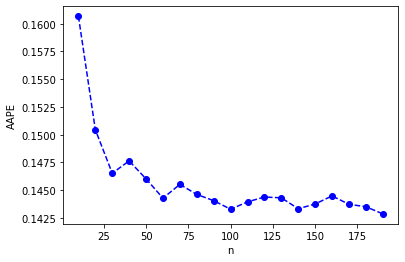

In [56]:
plt.plot(range(10,200,10), AAPE3,linestyle='--', marker='o', color='b')
plt.xlabel("n") 
plt.ylabel("AAPE") 

Text(0, 0.5, 'MAPE')

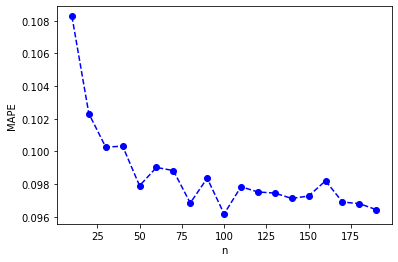

In [57]:
plt.plot(range(10,200,10), MAPE3,linestyle='--', marker='o', color='b')
plt.xlabel("n") 
plt.ylabel("MAPE")

After __n=100__, the errors reach a relatively low state and don't reduce much. Therefore, to reduce overfitting and save time, set __n=100__.

### Tune Parameter: max_features  Under Criterion: mae

First, set a large range of m and calculate cross-validation errors with large stepsize.

In [58]:
kf = KFold(n_splits=5, random_state = 1)

number = [i for i in range(10,211,20)]
AAPE=[]
MAPE=[]
 
for m in number:
    regr = RandomForestRegressor(max_features = m, n_estimators = 100, criterion = 'mae', n_jobs=-1)
    A=0
    M=0
    # For each split, we fit a model, and calculate the relative absolute error, and finally average these errors
    for train_index, test_index in kf.split(x_train):
        x_subtrain = x_train.iloc[train_index]
        y_subtrain = y_train.iloc[train_index]
        regr.fit(x_subtrain, y_subtrain)
        x_valid = x_train.iloc[test_index]
        y_valid = y_train.iloc[test_index]
        pred_y = regr.predict(x_valid)
        A+=aape(pred_y,y_valid)
        M+=mape(pred_y,y_valid)
    A/=5
    M/=5
    AAPE.append(A)
    MAPE.append(M)

Text(0, 0.5, 'AAPE')

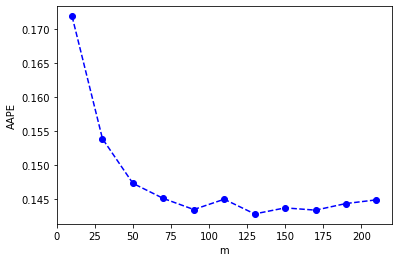

In [59]:
plt.plot(range(10,211,20), AAPE,linestyle='--', marker='o', color='b')
plt.xlabel("m") 
plt.ylabel("AAPE") 

Text(0, 0.5, 'MAPE')

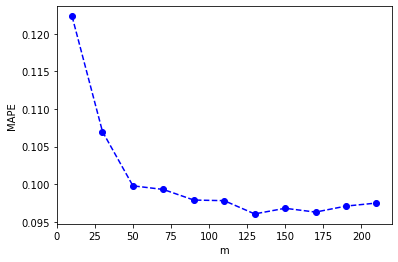

In [60]:
plt.plot(range(10,211,20), MAPE,linestyle='--', marker='o', color='b')
plt.xlabel("m") 
plt.ylabel("MAPE") 

Select __m in range (90, 130)__ and run models with finer stepsize.

In [61]:
number = [i for i in range(90,130,5)]
AAPE2=[]
MAPE2=[]
 
for m in number:
    regr = RandomForestRegressor(max_features = m, n_estimators = 100, criterion = 'mae', n_jobs=-1)
    A=0
    M=0
    # For each split, we fit a model, and calculate the relative absolute error, and finally average these errors
    for train_index, test_index in kf.split(x_train):
        x_subtrain = x_train.iloc[train_index]
        y_subtrain = y_train.iloc[train_index]
        regr.fit(x_subtrain, y_subtrain)
        x_valid = x_train.iloc[test_index]
        y_valid = y_train.iloc[test_index]
        pred_y = regr.predict(x_valid)
        A+=aape(pred_y,y_valid)
        M+=mape(pred_y,y_valid)
    A/=5
    M/=5
    AAPE2.append(A)
    MAPE2.append(M)

Text(0, 0.5, 'AAPE')

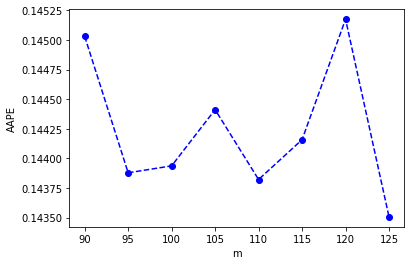

In [62]:
plt.plot(range(90,130,5), AAPE2,linestyle='--', marker='o', color='b')
plt.xlabel("m") 
plt.ylabel("AAPE") 

Text(0, 0.5, 'MAPE')

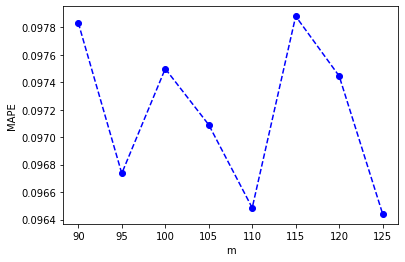

In [63]:
plt.plot(range(90,130,5), MAPE2,linestyle='--', marker='o', color='b')
plt.xlabel("m") 
plt.ylabel("MAPE") 

Select __m=100__.

In [64]:
# AAPE when m=100
AAPE2[2]

0.14393687710779718

### Tune Parameter: max_features Under Criterion: mse

In [65]:
kf = KFold(n_splits=5, random_state = 1)

number = [i for i in range(10,211,20)]
AAPE_mse=[]
MAPE_mse=[]
 
for m in number:
    regr = RandomForestRegressor(max_features = m, n_estimators = 100, criterion = 'mse', n_jobs=-1)
    A=0
    M=0
    # For each split, we fit a model, and calculate the relative absolute error, and finally average these errors
    for train_index, test_index in kf.split(x_train):
        x_subtrain = x_train.iloc[train_index]
        y_subtrain = y_train.iloc[train_index]
        regr.fit(x_subtrain, y_subtrain)
        x_valid = x_train.iloc[test_index]
        y_valid = y_train.iloc[test_index]
        pred_y = regr.predict(x_valid)
        A+=aape(pred_y,y_valid)
        M+=mape(pred_y,y_valid)
    A/=5
    M/=5
    AAPE_mse.append(A)
    MAPE_mse.append(M)

Text(0, 0.5, 'AAPE')

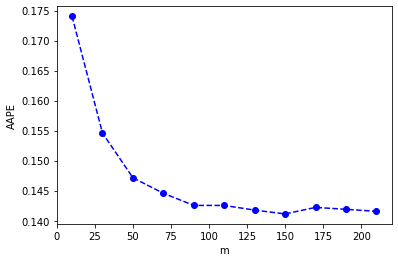

In [66]:
plt.plot(range(10,211,20), AAPE_mse,linestyle='--', marker='o', color='b')
plt.xlabel("m") 
plt.ylabel("AAPE")

Text(0, 0.5, 'MAPE')

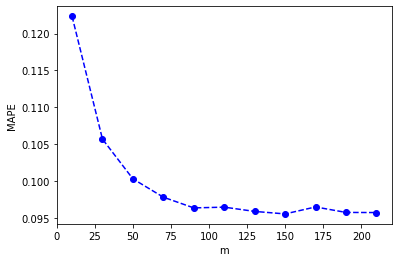

In [67]:
plt.plot(range(10,211,20), MAPE_mse,linestyle='--', marker='o', color='b')
plt.xlabel("m") 
plt.ylabel("MAPE") 

In [68]:
number = [i for i in range(100,201,5)]
AAPE_mse2=[]
MAPE_mse2=[]
 
for m in number:
    regr = RandomForestRegressor(max_features = m, n_estimators = 100, criterion = 'mse', n_jobs=-1)
    A=0
    M=0
    # For each split, we fit a model, and calculate the relative absolute error, and finally average these errors
    for train_index, test_index in kf.split(x_train):
        x_subtrain = x_train.iloc[train_index]
        y_subtrain = y_train.iloc[train_index]
        regr.fit(x_subtrain, y_subtrain)
        x_valid = x_train.iloc[test_index]
        y_valid = y_train.iloc[test_index]
        pred_y = regr.predict(x_valid)
        A+=aape(pred_y,y_valid)
        M+=mape(pred_y,y_valid)
    A/=5
    M/=5
    AAPE_mse2.append(A)
    MAPE_mse2.append(M)

Text(0, 0.5, 'AAPE')

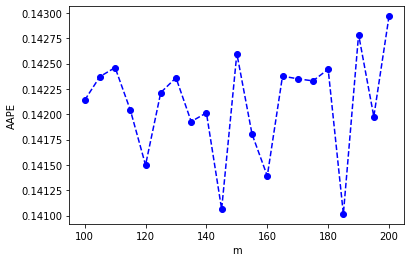

In [69]:
plt.plot(range(100,201,5), AAPE_mse2,linestyle='--', marker='o', color='b')
plt.xlabel("m") 
plt.ylabel("AAPE")

Text(0, 0.5, 'MAPE')

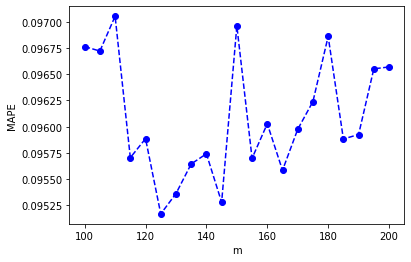

In [70]:
plt.plot(range(100,201,5), MAPE_mse2,linestyle='--', marker='o', color='b')
plt.xlabel("m") 
plt.ylabel("MAPE") 

Select __m=145__ based on the above 2 figures.

In [71]:
# AAPE when m=145
AAPE_mse2[9]

0.14106392069409177

Display the tuning result as below:

|Criterion|max_features|AAPE  |
|---------|------------|------|
|mae      |100         |0.144 |
|mse      |145         |0.141 |

Determine the final model: Random Forest Regression

Parameters:

- n_estimators = 100
- max_features = 145
- criterion = 'mse'

## Model Report

### Run the Final Model

Run random forest regression model with parameters above with the whole training data.

In [72]:
regr_final = RandomForestRegressor(max_features = 145, n_estimators = 100,criterion = 'mse')
regr_final.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=145, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Self-check Prediction Errors

Self-check the final model with AAPE and MAPE.

In [73]:
pred_y = regr_final.predict(x_train)
print(aape(pred_y,y_train))
print(mape(pred_y,y_train))

0.04703799909690283
0.030260377358490565


Print out the number of predictions with large relative absolute errors.

In [74]:
d = np.absolute(y_train - pred_y)
d = np.divide(d,pred_y)
print(len([i for i in d if i>0.2]))
print(len([i for i in d if i>0.4]))
print(len([i for i in d if i>0.5]))

139
7
3


The AAPE and MAPE are rather low by self-check, but there are still a few rows of predictions that suffer high relative absolute error.

### Feature Importance

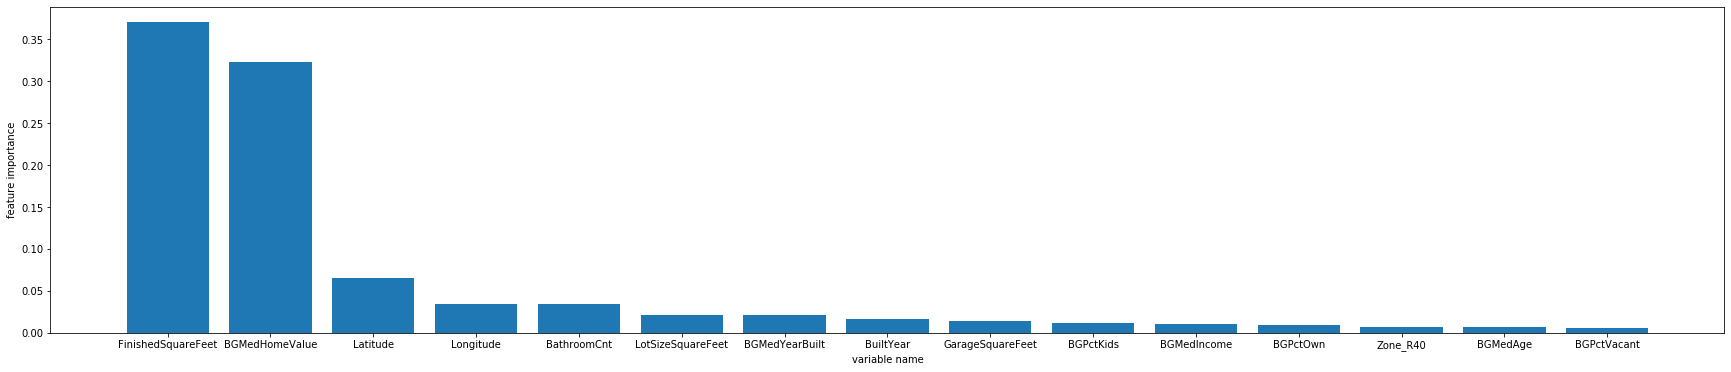

In [75]:
variable_importance = []
for i in range(len(x_train.columns)):
    variable_importance.append((x_train.columns[i],regr_final.feature_importances_[i]))
    
variable_importance.sort(key = operator.itemgetter(1), reverse=True)

selected = variable_importance[0:15]
selected_variable = [x[0] for x in selected]
selected_importance = [x[1] for x in selected]
plt.figure(figsize=(30,6))
plt.bar(selected_variable,selected_importance)
plt.xlabel("variable name")
plt.ylabel("feature importance")
plt.show()

The top 3 important features are `FinishedSquareFeet`, `BGMedHomeValue`, and `Latitude`. Surprisingly, `BathroomCnt` stands out as the fifth important feature, taking up to 5% importance contribution to the `SaleDollarCnt`. 

From this feature importance rank, features that we did regression to impute missing values previously, are of good importance. `BGMedHomeValue`, and `BGMedYearBuilt` rank as the __2nd and 7th__ among the 223 features. It is a good choice to impute them with cautious regression rather than simpler methods.

## Model Output

In [77]:
# Final prediction
x_test=test.iloc[:,2:]
y_test=regr_final.predict(x_test)

# Replace SaleDollarCnt in test set with predicted results
y_test_df=pd.DataFrame(y_test,index=test.index)
for i in test.index:
    test.SaleDollarCnt[i]=y_test_df[0][i]

# Export as csv
result=test.iloc[:,:2]
result.to_csv('ZExercise result.csv',index=False)

## Further Discussion

__1. Missing Data Imputation__

Here in this problem, I chose to use KNN regression to impute `BGMedHomeValue`, `BGMedRent` and `BGMedYearBuilt`, because they contribute to over 20% of the total dataset, and I have no clue what certain kind of data is missing. During the process, I also tried to directly remove all rows with NaN, and do the random forest model training with the 80% data remaining. It turned out that the cross validation AAPE in this scenario didn't increase much. Personally I think these two ways of handling missing values are both acceptable, but imputing with regression is a more cautious way.


__2. Model Training Criterion__

In the RandonForestRegressor package in sklearn, the parameter "criterion", which stands for the the function to measure the quality of a split, only supports criteria “mse” for the mean squared error, and “mae” for the mean absolute error. However, the evaluation metrics we use is AAPE, the average absolute percentage error. The difference between the metrics in the model training and model evaluation will certainly result to a not very ideal test error result. We can see from the cross validation result, that after tuning the parameters, the AAPE is still as high as 14%. 

To fix this problem, one can alter the RandomForestReressor package, and switch the "criterion" into "AAPE". This requires a lot of software developing skills. One thing I can help is that, under the criterion of AAPE, how we can reach to the predicted value from a mathematical perspective.

Suppose in one leaf node, we have outcomes from training data labelled as $y_1$, $y_2$, ..., $y_n$. In this case all $y_i > 0$. The predicted value $y_p$ is the value where AAPE is minimized. After applying derivative of the error function, we can land to the following steps of finding $y_p$:

1) Sort $y_i$. $y_1 < y_2 <...< y_n$

2) find a $m$ where $1/y_1 + 1/y_2 +...+ 1/y_{m-1} < 1/y_m +...+ 1/y_n$, and $1/y_1 + 1/y_2 +...+ 1/y_m > 1/y_{m+1} +...+ 1/y_n$

3) $y_p = y_m$


__3. Nonlinear Conbination of Features__

Besides the criterion problem, there might be other aspects that my model can be improved. Adding nonlinear combination of features as new features, i.e. $x^n_i, x_ix_j, x_i/x_j$ to the model should be considered. I considered `PriceSF`, `BGMedHomeValue`/`FinishedSquareFeet`, but it didn't reduce the model AAPE. There can be other choices that both reduce model error and have business sense.
